# Create a spectorgram from a nanopore read
1. downloads sample fast5 files from Chiron github repo if needed
2. Demonstrates how to create a spectrogram. 
    * the ppx matrix will be used as input to our model
    * play around with following parameters
        - nfft, the window length
        - noverlap, the window overlap
        - pad_to, allows us to select frequencies of interest
3. Demonstrates how to remove white noise from a signal.
    * play around with the following parameters
        - changing the value of sigma used with gaussian filter
        - try other filters, 'box car', 'triangle' ...

Most speech recognition models convert the raw time domain signal to frequency data. Does removing white noise help? Maybe speed learning or allow for simple model? Most models I have seen are careful to train on sample that include background noise so that the model is more likely to work in the real world. Example of background noise might be a coffee shop. This is not the same as white noise. White noise is assumed to be equally distributed across all frequencies and have a standard deviation of 's'

ref:
* [Matplotlib specgram()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html)
* [Chiron github repo](https://github.com/haotianteng/Chiron)
* [Chiron: Translating nanopore raw signal directly into nucleotide sequence using deep learning](https://www.biorxiv.org/content/early/2017/09/12/179531)
* [https://terpconnect.umd.edu/~toh/spectrum/Smoothing.html](https://terpconnect.umd.edu/~toh/spectrum/Smoothing.html)
* [Ensemble Averaging](https://terpconnect.umd.edu/~toh/spectrum/SignalsAndNoise.html#EnsembleAveraging)

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

%matplotlib inline

/Users/andrewdavidson/workSpace/pythonEnv/DeepBio/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## load a sample signal file

In [2]:
import os
import requests

file_name = "read1.fast5" # read2.fast5 read3.fast4 read5.fast5 
fast5_path = "data/" + file_name
# note the download url is not the same as the url you use when you view the file in github
# notice 'raw' and 'blob' are different
#read_fast5_url = "https://github.com/haotianteng/Chiron/blob/master/chiron/example_data/" + file_name
read_fast5_url = "https://raw.github.com/haotianteng/Chiron/master/chiron/example_data/" + file_name

if not os.path.exists(fast5_path):
    directory = os.path.dirname(fast5_path )
    if not os.path.exists(directory):
        os.makedirs(directory)
    r = requests.get(read_fast5_url)
    r.raise_for_status()
    with open(fast5_path, "wb") as f:
        for chunk in r.iter_content(32768):
            f.write(chunk)    

In [3]:
with h5py.File(fast5_path, 'r') as fast5_data :
    # Get samping rate
    fast5_info = fast5_data['UniqueGlobalKey/channel_id'].attrs
    sampling_rate = fast5_info['sampling_rate'].astype('int_')     
#     raw_dat = fast5_data['/Raw/Reads/'].values()[0]
    raw_data_set = fast5_data['/Raw/Reads/Read_104/Signal'] # .values()[0]
    #raw_data = raw_dat['Signal'].values()
    raw_data = raw_data_set[:]


n = len(raw_data)
print("sampling_rate:", sampling_rate)
print("n:", n)
print("time in sec:", n / sampling_rate)

sampling_rate: 4000
n: 62461
time in sec: 15.61525


## Create graphs
Try changing the window size, overlap, and padding to get feel for how to tune parameters. We want the window to probably be at most a 2 * the expected length of segment. The range of the frequence will always [0, ... fs/2]. We can use padding to tune how many frequences in the range we want.

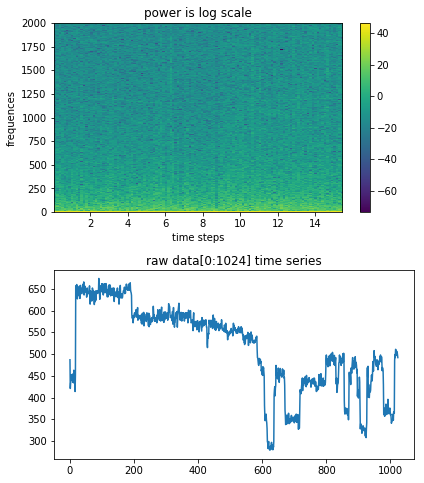

nfft:1024 noverlap:512 sample_rate:4000 num_windows:120.0
pxx.shape:(513, 120)
freqs.shape:(513,) min:0.0 max:2000.0
bins.shape:(120,)


In [4]:
# pxx is the segments x freqs array of instantaneous power,
# freqs is the frequency vector,
# bins are the centers of the time bins in which the power is 
#      computed,
# im is the matplotlib.image.AxesImage instance

fig = plt.figure(figsize=(6,10))
grid = 311 # nrow, ncol, place in grid
plt.subplot(grid) 
    
nfft = 1024
noverlap = int( nfft / 2 )
pxx, freqs, bins, im = plt.specgram(raw_data, NFFT=nfft, Fs=sampling_rate, 
                                    noverlap=noverlap, 
#                                         scale='linear'
                                   )

plt.xlabel("time steps")
plt.ylabel("frequences")
plt.title("power is log scale")
fig.colorbar(im)

grid +=1 
plt.subplot(grid) # nrow, ncol, place in grid
plt.plot(raw_data[0:nfft])
plt.title("raw data[0:" + str(nfft) + "] time series")
    
plt.tight_layout() # adjust so that labels do not over lap

plt.show()

num_windows = np.floor( (len(raw_data) - nfft)/noverlap ) + 1
print("nfft:{} noverlap:{} sample_rate:{} num_windows:{}".format(nfft, noverlap, sampling_rate, num_windows))
print("pxx.shape:{}".format(pxx.shape) )
print("freqs.shape:{} min:{} max:{}".format(freqs.shape, np.min(freqs), np.max(freqs)) )
print("bins.shape:{}".format(bins.shape) )

# Normalize the raw signal
Chiron normalizes the time series data in a preprocessing step. Typically normialization is done to allow model to train faster. The range of values is now [-3, ... 3] instead of [0, ... 700]

<span style="color:red">TODO: should we normalize? before or after FFT? </span>

Text(0,0.5,'Z')

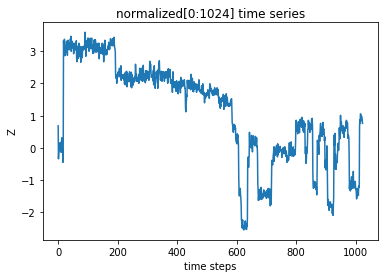

In [5]:
norm = (raw_data - np.mean(raw_data) ) / np.std(raw_data)
plt.plot(norm[0:nfft])
plt.title("normalized[0:" + str(nfft) + "] time series")
plt.xlabel("time steps")
plt.ylabel("Z")

## Removing White Noise

Uses a gausian filter. 
ref: [https://terpconnect.umd.edu/~toh/spectrum/Smoothing.html](https://terpconnect.umd.edu/~toh/spectrum/Smoothing.html)

* see section on 'when to use smoothing' and 'when not to use smoothing'
* ??? I think our samples have ??? coverage????. I.e. the there are several pores. Maybe use [Ensemble Averaging](https://terpconnect.umd.edu/~toh/spectrum/SignalsAndNoise.html#EnsembleAveraging)

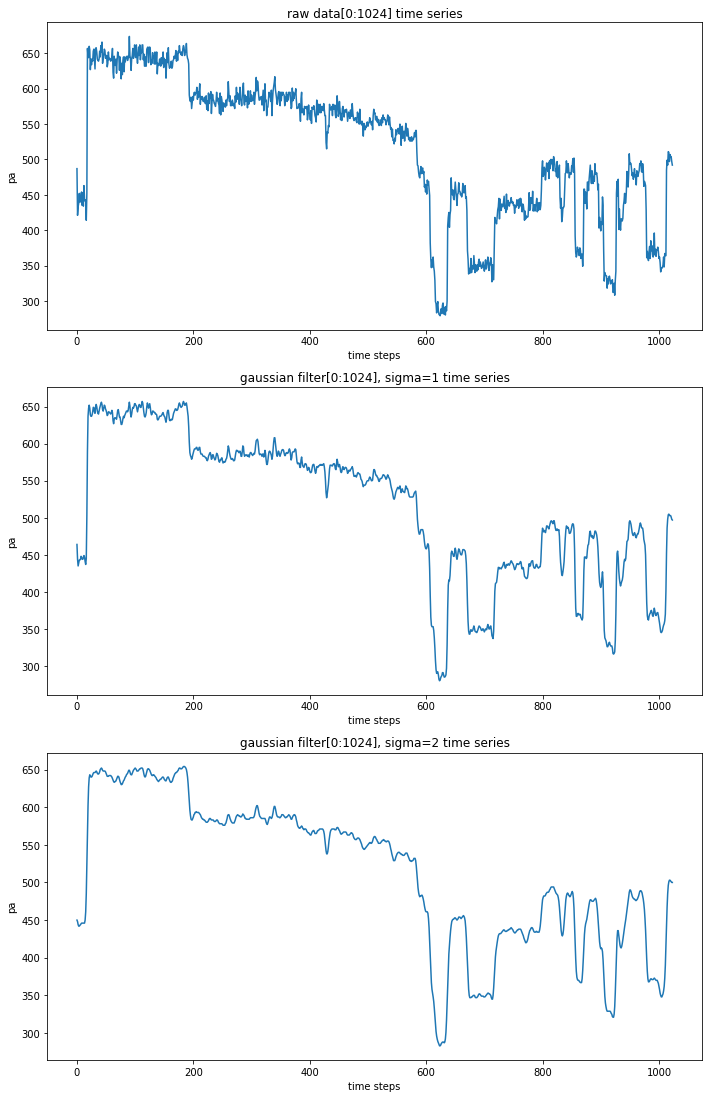

In [6]:
fig = plt.figure(figsize=(10,20))
grid = 411 # nrow, ncol, place in grid
plt.subplot(grid) 

#########
plt.plot(raw_data[0:nfft])
plt.title("raw data[0:" + str(nfft) + "] time series")
plt.xlabel("time steps")
plt.ylabel("pa")

#########
grid +=1 
plt.subplot(grid) # nrow, ncol, place in grid

#what should sigma be?
sigma = 1
gf = gaussian_filter1d(raw_data, sigma)
plt.plot(gf[0:nfft])
plt.title("gaussian filter[0:" + str(nfft) + "], sigma=" + str(sigma) + " time series")
plt.xlabel("time steps")
plt.ylabel("pa")

#########
grid +=1 
plt.subplot(grid) # nrow, ncol, place in grid

#what should sigma be?
sigma = 2
gf = gaussian_filter1d(raw_data, sigma)
plt.plot(gf[0:nfft])
plt.title("gaussian filter[0:" + str(nfft) + "], sigma=" + str(sigma) + " time series")
plt.xlabel("time steps")
plt.ylabel("pa")

#######
plt.tight_layout() # adjust so that labels do not over lap
plt.show()

## Compare filtered and unfiltered spectrograms
Should we remove white noise?

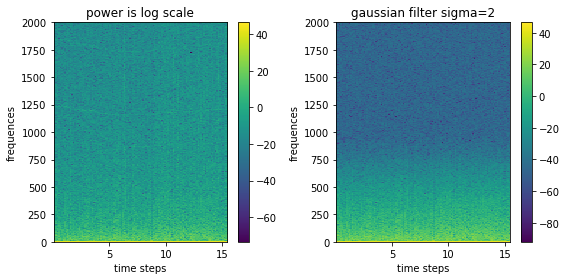

In [7]:
nfft = 1024
noverlap = int( nfft / 2 )

fig = plt.figure(figsize=(8,4)) #figsize=(6,8)
grid = 121 # nrow, ncol, place in grid
plt.subplot(grid) 
    
#######
pxx, freqs, bins, im = plt.specgram(raw_data, NFFT=nfft, Fs=sampling_rate, 
                                    noverlap=noverlap, 
#                                         scale='linear'
                                   )
plt.xlabel("time steps")
plt.ylabel("frequences")
plt.title("power is log scale")
fig.colorbar(im)

#######
grid += 1
plt.subplot(grid) # nrow, ncol, place in grid
sigma = 2
pxxFiltered, freqsFiltered, binsFiltered, imFiltered = plt.specgram(gaussian_filter1d(raw_data, sigma),
                                                                    NFFT=nfft, Fs=sampling_rate, 
                                    noverlap=noverlap, 
#                                         scale='linear'
                                   )
plt.xlabel("time steps")
plt.ylabel("frequences")
sigma = 2
plt.title("gaussian filter sigma=" + str(sigma))
fig.colorbar(imFiltered)

#######
plt.tight_layout() # adjust so that labels do not over lap
plt.show()

In [8]:
print("        pxx.shape:", pxx.shape)
print("pxxFiltered.shape:", pxxFiltered.shape)

np.max(pxx)         # 44924.98624861031
np.max(pxxFiltered) # 44837.18577262292
indices = np.where(pxx == pxx.max())
print(indices) # (array([0]), array([0]))

indices = np.where(pxx == pxx.min())
print(indices) # (array([441]), array([94]))

        pxx.shape: (513, 120)
pxxFiltered.shape: (513, 120)
(array([0]), array([0]))
(array([441]), array([94]))


In [9]:
print("sum(noise)          : {:>12.4f}".format(np.sum( pxx - pxxFiltered))) 
print("sum(filtered signal): {:>12.4f}".format(np.sum(pxxFiltered))) 

sum(noise)          :   25973.8736
sum(filtered signal): 6081618.6315


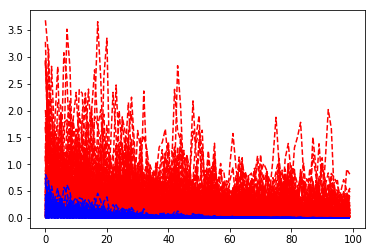

In [10]:
fig = plt.figure()
p1 = plt.plot(pxx[100:200,:], 'r--', label='a') # , label='raw'
p2 = plt.plot(pxxFiltered[100:200,:], 'b--', label='b') # , label='with out noise'
#plt.legend() # loc='upper left'
#plt.legend(loc='upper left')
plt.show()

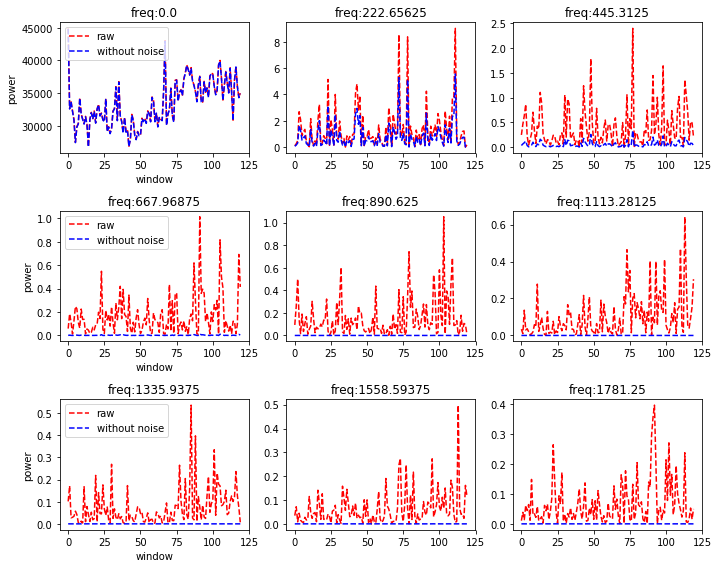

In [11]:
def filterVsRaw(grid, rawPXX, filteredPXX, freqIdx, freqs, first=False) :
    plt.subplot(grid)
    p1 = plt.plot(rawPXX[freqIdx,:], 'r--', label='raw') # , label='raw'
    p2 = plt.plot(filteredPXX[freqIdx,:], 'b--', label='without noise') # , label='with out noise'
    plt.title("freq:" + str(freqs[freqIdx]) )

    if first:
        plt.legend(loc='upper left')
        plt.xlabel("window")
        plt.ylabel("power")
  
fig = plt.figure(figsize=(10,8))
grid = 331
freq = 57
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq*0), freqs=freqsFiltered, first=True)
grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 1), freqs=freqsFiltered)
grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 2), freqs=freqsFiltered)


grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 3), freqs=freqsFiltered, first=True)
grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 4), freqs=freqsFiltered)
grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 5), freqs=freqsFiltered)


grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 6), freqs=freqsFiltered, first=True)
grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 7), freqs=freqsFiltered)
grid += 1
filterVsRaw(grid, pxx, pxxFiltered, freqIdx=(freq * 8), freqs=freqsFiltered)
    
###
plt.tight_layout()
plt.show()    